## PREOPS-5154: Investigate nDiaSource as a function of initial_pvi summary stats metrics

**Description**

Make plots of nDiaSource vs. "metric", where "metric" includes those present in the initial_pvi.summaryStats dataset related to astrometric and psf model fidelity.  The idea is to look for any correlations that may help indicate root causes of increased false positives. 

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import operator
import pickle

# This is a collection of utils in my ~/Python dir.  I'll just include
# the two functions I used from it in this notebook.
# import bokehPlotUtils as bkPlotUtils

import lsst.daf.butler as dafButler
from lsst.pipe.base import Struct

In [2]:
# File persistence settings
dataDir = "/sdf/data/rubin/user/laurenma/tickets/DiaSrcSprint/"  # where to save the datafiles
plotDir = "/sdf/home/l/laurenma/public_html/PREOPS-5154/"  # where to save the figures
doSaveFigs = False  # set to True if you'd like the figures to get persisted to plotDir

In [3]:
# Butler repo and collection information
repoRoot = "/repo/embargo"
collection = "u/elhoward/DM-44138/LSSTComCamSim"
collectionStr = collection.replace("/", "_")
instrument = "LSSTComCamSim"
skymapName = "ops_rehersal_prep_2k_v1"

In [4]:
# Initialize the butler and determine the detector list for the associated camera
butler = dafButler.Butler(repoRoot, collections=collection, instrument=instrument, skymap=skymapName)
registry = butler.registry
camera = butler.get("camera", instrument=instrument)
detectors = []
for det in camera:
    detectors.append(det.getId())
print("Number of detectors for {} = {}".format(instrument, len(detectors)))

Number of detectors for LSSTComCamSim = 9


In [5]:
# Set the dataset to read in and some flags for identifying "good" diaSources
datasetType = "goodSeeingDiff_diaSrcTable"
badFlagList=["pixelFlags_edge", "pixelFlags_bad", "pixelFlags_suspect",
             "pixelFlags_interpolatedCenter", "pixelFlags_saturatedCenter"]

In [6]:
# Group tracts based on RA/Dec clustering
group1 = [3384, 3385]
group2 = [2261, 2262, 2494, 2495]
group3 = [9880, 9881, 9638]
group4 = [3533, 3534, 3345, 3346]
group5 = [7683, 7684, 7445, 7446]
group6 = [9590, 9591, 9347, 9348]
group7 = [9812, 9813]
group8 = [7149, 6914, 6915]

groups = [group1, group2, group3, group4, group5, group6, group7, group8]

In [7]:
def setUnitsDict():
    unitsDict=dict(
        astromOffsetMean="arcsec",
        astromOffsetStd="arcsec",
        psfSigma="pixels",
        psfFwhm="arcsec",
        skyBg="counts",
        skyNoise="counts",
        visit="number",
        seqNum="number",
        detector="number",
        zenithDistance="degrees",
        zeroPoint="mag",
        expTimeScaledZp="mag",
        ra="degrees",
        dec="degrees",
        xFp="mm",
        yFp="mm",
        medianE="",
        psfStarScaledDeltaSizeScatter="",
        psfTraceRadiusDelta="pixels",
        psfApFluxDelta="normalized",
        psfApCorrDelta="factor",
        maxDistToNearestPsf="pixles",
        effTime="sec",
        effTimePsfSigmaScale="",
        effTimeSkyBgScale="",
        effTimeZeroPointScale="",
    )
    return unitsDict

In [8]:
def setThresholds(instrument=None):
    # Default to stack defaults (largely conditioned on HSC data):
    maxMeanDistanceArcsec = 0.5
    maxEllipResidual = 0.007
    maxScaledSizeScatter = 0.019
    maxPsfTraceRadiusDelta = 0.7
    maxPsfApFluxDelta = 0.19
    maxPsfApCorrDelta = 0.26

    if instrument == "LSSTCam-imSim":
        maxMeanDistanceArcsec = 0.05
        maxEllipResidual = 0.0035
        maxScaledSizeScatter = 0.0115
        maxPsfTraceRadiusDelta = 0.1
        maxPsfApFluxDelta = 0.056
        maxPsfApCorrDelta = 0.075
    elif instrument == "LSSTComCamSim":
        maxEllipResidual = 0.0027
        maxScaledSizeScatter = 0.015
        maxPsfTraceRadiusDelta = 0.09
        maxPsfApFluxDelta = 0.039
        maxPsfApCorrDelta = 0.058
    elif instrument == "LATISS":
        maxEllipResidual = 0.1
        maxScaledSizeScatter = 0.025
        maxPsfTraceRadiusDelta = 4.8

    return Struct(
        maxMeanDistanceArcsec=maxMeanDistanceArcsec,
        maxEllipResidual=maxEllipResidual,
        maxScaledSizeScatter=maxScaledSizeScatter,
        maxPsfTraceRadiusDelta=maxPsfTraceRadiusDelta,
        maxPsfApFluxDelta=maxPsfApFluxDelta,
        maxPsfApCorrDelta=maxPsfApCorrDelta,
    )

In [9]:
def getUniqueVisits(collection, tracts):
    """Get the unique list of visits in a collection for a given group
    of tracts.
    """
    visitList = []
    tracts = ",".join(str(tract) for tract in tracts)
    for d in sorted(registry.queryDatasets(datasetType=datasetType, collections=collection, where=f"skymap='{skymapName}' AND tract IN ({tracts})")): 
        visitList.append(d.dataId["visit"])
    uniqueVisits = list(set(visitList))
    return uniqueVisits

In [10]:
def getBandPerVisitList(registry, collection, visitList):
    """Get the bands for the visits of interest"""
    bandList = []
    visits = ",".join(str(visit) for visit in visitList)
    for d in sorted(registry.queryDatasets(datasetType=datasetType, collections=collection, where=f"skymap='{skymapName}' AND visit IN ({visits})")): 
        bandList.append(d.dataId["band"])
    return bandList

In [11]:
def getDiaSourcesAndMetrics(butler, visitList, detectors, badFlagList=None):
    """Count the number of diaSources and collect their associated 
    metrics and parameters the from initial_pvi.summaryStats dataset 
    for each detector in a given list of visits.

    THIS TAKES FOREVER...ONLY DO IT ONCE!

    Parameters
    ----------
    butler : `lsst.daf.butler`
    visitList : `list` of `int`
    detectors : `list` of `int`
    badFlagList : `list`, optional

    Returns
    -------
    retrunStruct : `lsst.pipe.base.Struct` 
        With attributes:

        ``detectorList``
            A list of the detector Id numbers (`list` of `int`).
        ``nDiaSourceList``
            A per-detector list of the counts of all diaSources (`list` of `int`).
        ``nGoodDiaSourceList``
            A per-detector list of the counts of diaSources without any of 
            the flags in ``badFlagsList`` set (`list` of `int`).
        ``psfSigmaList``
            A per-detector list of the radius of the PSF sigma in pixels,
            from the initial_pvi.summaryStats (`list` of `float`).
        ``skyBgList``
            A per-detector list of the sky background (`list` of `float`).
        ``astromOffsetMeanList``
            A per-detector list of this metric from the initial_pvi.summaryStats
            (`list` of `float`).
        ``medianEList``
            A per-detector list of this metric from the initial_pvi.summaryStats
            (`list` of `float`).
        ``psfStarDeltaSizeScatterList``
            A per-detector list of this metric from the initial_pvi.summaryStats
            (`list` of `float`).
        ``psfTraceRadiusDeltaList``
            A per-detector list of this metric from the initial_pvi.summaryStats
            (`list` of `float`).
     """
    detectorList = []
    bandList = []
    nDiaSourceList = []
    nGoodDiaSourceList = []
    psfSigmaList = []
    skyBgList = []
    astromOffsetMeanList = []
    medianEList = []
    psfStarDeltaSizeScatterList = []
    psfTraceRadiusDeltaList = []

    for visit in visitList:
        for detector in detectors:
            summaryStats = butler.get("initial_pvi.summaryStats", visit=visit, detector=detector)
            detectorList.append(detector)        
            psfSigmaList.append(summaryStats.psfSigma)
            skyBgList.append(summaryStats.skyBg)
            astromOffsetMeanList.append(summaryStats.astromOffsetMean)
            medianE = np.sqrt(summaryStats.psfStarDeltaE1Median**2 + summaryStats.psfStarDeltaE2Median**2.)
            medianEList.append(medianE)
            psfStarDeltaSizeScatterList.append(summaryStats.psfStarDeltaSizeScatter)
            psfTraceRadiusDeltaList.append(summaryStats.psfTraceRadiusDelta)
        
            diaSourceTable = butler.get(datasetType, visit=visit, detector=detector)
            nDiaSourceList.append(len(diaSourceTable))
            if badFlagList:
                badFlags = [diaSourceTable[flag] for flag in badFlagList]
                flagFilter = functools.reduce(operator.or_, badFlags)
                noFlagFilter = ~flagFilter
                nGoodDiaSourceList.append(len(diaSourceTable.loc[noFlagFilter]))
            else:
                nGoodDiaSourceList.append(len(diaSourceTable))

    return Struct(
        detectorList=detectorList,
        nDiaSourceList=nDiaSourceList,
        nGoodDiaSourceList=nGoodDiaSourceList,
        psfSigmaList=psfSigmaList,
        skyBgList=skyBgList,
        astromOffsetMeanList=astromOffsetMeanList,
        medianEList=medianEList,
        psfStarDeltaSizeScatterList=psfStarDeltaSizeScatterList,
        psfTraceRadiusDeltaList=psfTraceRadiusDeltaList,
    )

In [ ]:
# Collect all the relevant data per group by looping through all dataIds.
# This takes forever...don't do it more than once!  And next time maybe save as a dataframe...
if False:
    groupNum = 0
    for group in groups:
        groupNum += 1
        visitList = getUniqueVisits(collection, group)
        bandList = getBandPerVisitList(collection, visitList)
        groupStruct = getGoodDiaSources(butler, visitList, detectors, badFlagList=badFlagList)
        with open("{}group{}.pickle".format(dataDir, groupNum), "wb") as handle:
            pickle.dump(groupStruct, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Read in the data you pickled in the cell above to pass to the plot routine
groupStructDict = {}
groupNum = 0
for group in groups:
    groupNum += 1
    tracts = ",".join(str(tract) for tract in group)
    with open("{}group{}.pickle".format(dataDir, groupNum), "rb") as handle:
        groupStructDict[tracts] = pickle.load(handle)

In [13]:
# Make the plots of nDiaSources vs. metric, color-coded by tract group.
# For each plot, the left plot shows the number of “good” diaSources, having
# culled on the flags in badFlagList and the right panel shows “all” diaSources
# (no culling).
def makePlot(resultStructDict, xMetric):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    unitsDict =  setUnitsDict()  # bkPlotUtils.setUnitsDict()
    threshStruct = setThresholds(instrument=instrument)
    # threshStruct = bkPlotUtils.introspectConfigs(instrument, butler=None)
    xThresh = None
    numRej = 0
    nTotal = 0
    plt.yscale("log")
    ax1.set_ylabel("N diaSources (per detector)")
    ax1.set_xlabel("{} ({})".format(xMetric, unitsDict[xMetric]))
    ax2.set_xlabel("{} ({})".format(xMetric, unitsDict[xMetric]))
    for resultStructKey, resultStruct in resultStructDict.items():
        if xMetric == "astromOffsetMean":
            xData = resultStruct.astromOffsetMean
        if xMetric == "medianE":
            xData = resultStruct.medianEList
            xThresh = threshStruct.maxEllipResidual
        if xMetric == "psfStarScaledDeltaSizeScatter":
            xData = resultStruct.psfStarDeltaSizeScatterList
            xThresh = threshStruct.maxScaledSizeScatter
        if xMetric == "psfTraceRadiusDelta":
            xData = resultStruct.psfTraceRadiusDeltaList
            xThresh = threshStruct.maxPsfTraceRadiusDelta
        if xMetric == "skyBg":
            xData = resultStruct.skyBgList
        if xMetric == "psfSigma":
            xData = resultStruct.psfSigmaList
        nTotal += len(xData)
        if xThresh is not None:
            numRej += sum(xDat > xThresh for xDat in xData)
        titleStr = "Good DiaSources (nData = {})".format(nTotal)
        ax1.set_title(titleStr, fontsize=10)
        yLab = 0.99
        for flag in badFlagList:
            yLab -= 0.05
            ax1.text(0.63, yLab, flag, transform = ax1.transAxes, fontsize=7)
        ax1.scatter(xData, resultStruct.nGoodDiaSourceList, marker=".", alpha=0.4,
                    label=f"{resultStructKey}")
        titleStr = "All DiaSources (no culling on flags) (nData = {})".format(nTotal)
        ax2.set_title(titleStr, fontsize=10)
        ax2.scatter(xData, resultStruct.nDiaSourceList, marker=".", alpha=0.5,
                    label=f"{resultStructKey}")
    # Even though these thresholds are not used in ap processing, they are
    # still reasonably useful for setting the plot limits.
    if xThresh is not None:
        for ax in [ax1, ax2]:
            xLim0 = max(-xThresh/5, ax.get_xlim()[0])
            xLim1 = min(5*xThresh, ax.get_xlim()[1])
            ax.set_xlim((xLim0, xLim1))

    plt.legend(fontsize=8)
    if doSaveFigs:
        filename = "{}{}_nDiaSrc_vs_{}".format(plotDir, collectionStr, xMetric)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)

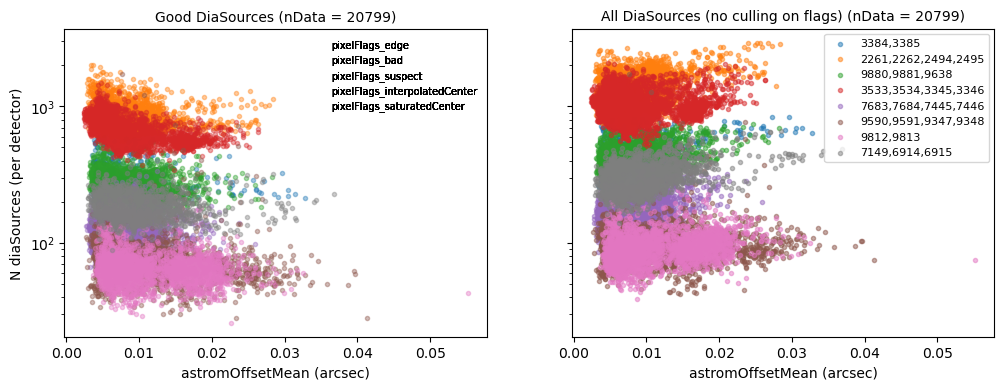

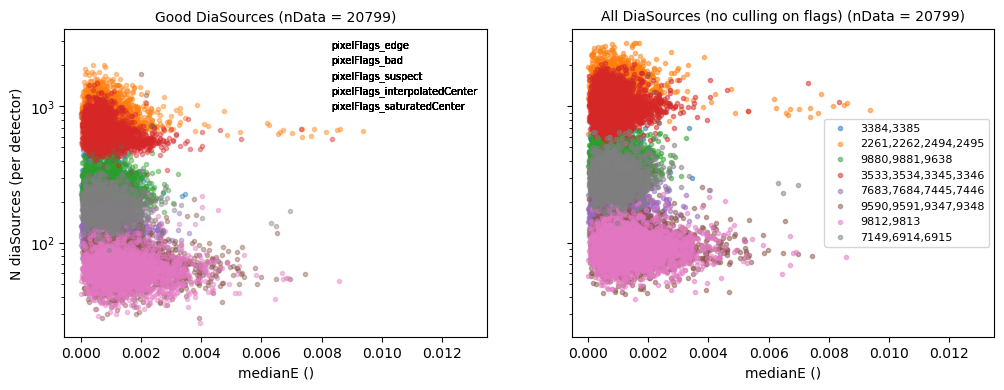

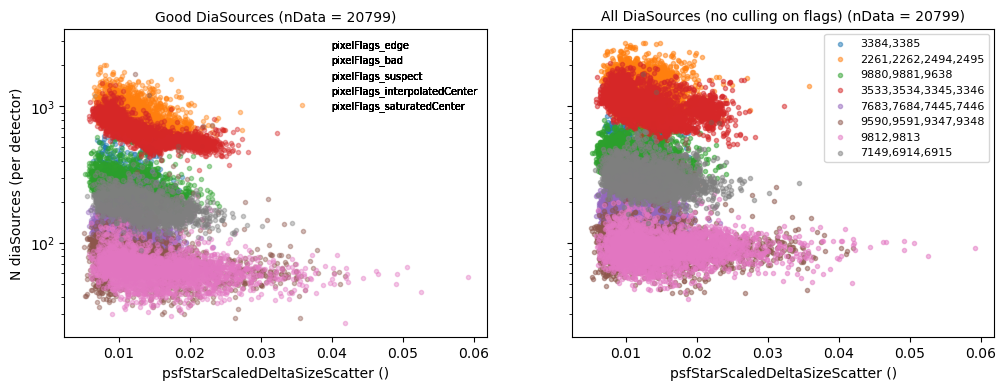

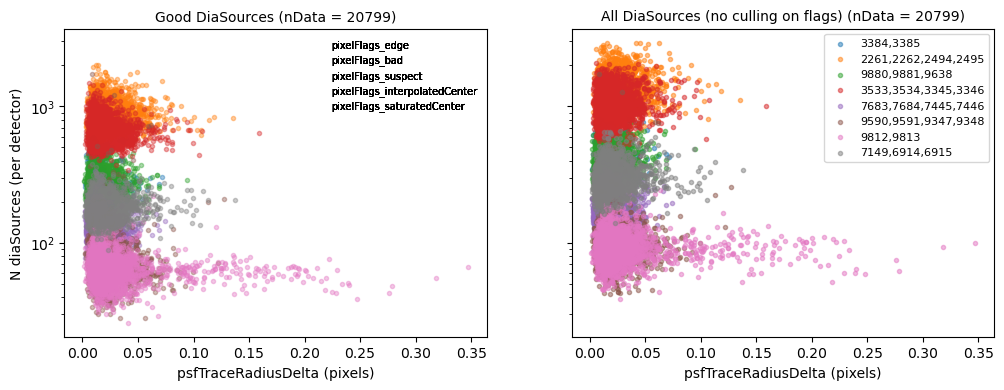

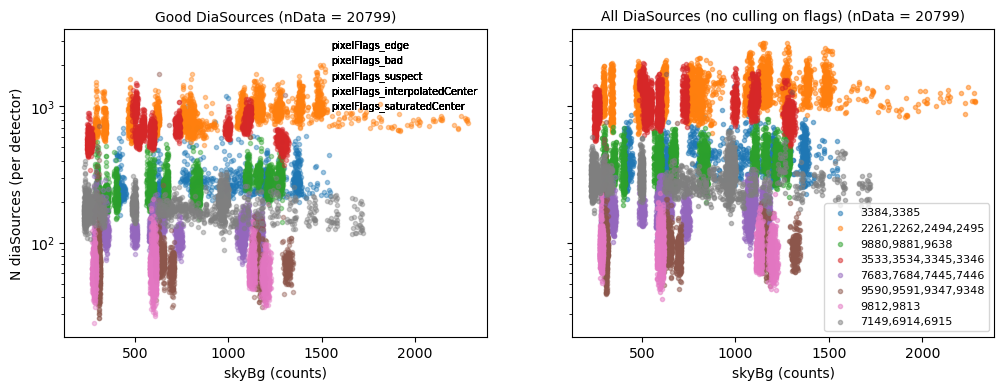

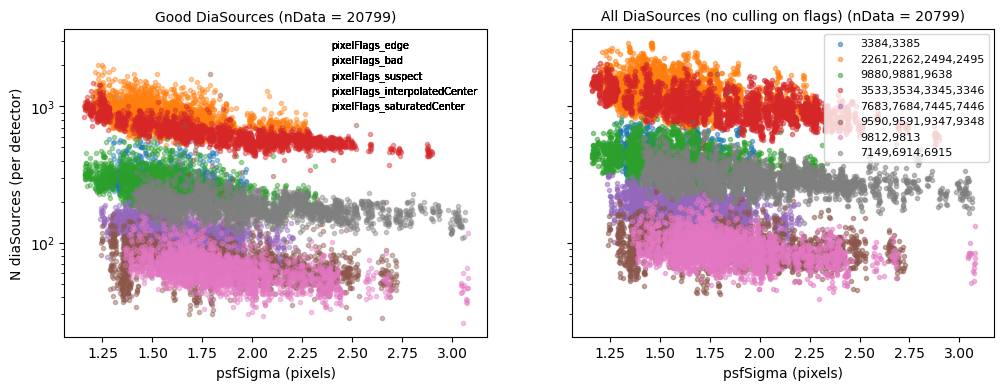

In [14]:
# List of "metrics" to plot against
xMetricList = ["astromOffsetMean", "medianE", "psfStarScaledDeltaSizeScatter", 
               "psfTraceRadiusDelta", "skyBg", "psfSigma"]
# Loop through the metric list and create the plot for each one
for xMetric in xMetricList:
    makePlot(groupStructDict, xMetric)